# LDA implementation

## Loading libraries

In [1]:
# Load libraries
import logging
import pyro

import pandas as pd

from pyro.infer.autoguide import AutoDelta
from pyro import poutine

from zzz_utils import *
from lda import *

import matplotlib.pyplot as plt

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

pyro.clear_param_store()
pyro.set_rng_seed(123)

## LDA model

First we simulate a toy dataset to render the Pyro models.

In [2]:
nTopics = 3    # Topics
nCells = 20    # Cells
nRegions = 10 # Regions
N = [5] * nCells # Cells size

# Simulate data
obj = simulate_lda_dataset(nTopics = nTopics, nCells = nCells, 
                           nRegions = nRegions, N = N, 
                           a = torch.ones(nTopics), b = torch.ones(nRegions))
# transpose so it matches Pyro's input
D = torch.from_numpy(obj['D'].transpose())

Below we define the LDA model with Pyro. Note that data D is a matrix of __nCounts x nCells__, and here we assume that __nCounts__ is the same across cells.

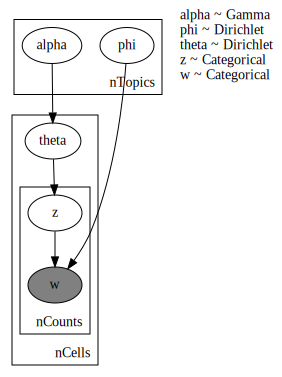

In [3]:
pyro.clear_param_store()
pyro.render_model(lda_model, model_args=(D, nTopics, nRegions), 
                  render_distributions=True, render_params=True)

In [4]:
#trace = pyro.poutine.trace(lda_model).get_trace()
#trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
#print(trace.format_shapes())

## LDA guide (variational approximation)

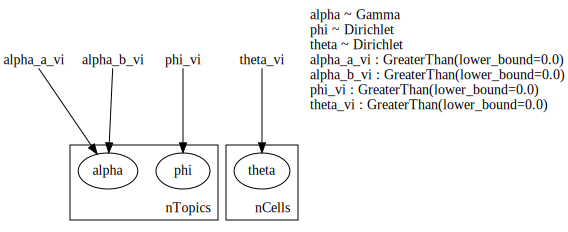

In [5]:
pyro.clear_param_store()
pyro.render_model(lda_guide, model_args=(D, nTopics, nRegions), 
                  render_distributions=True, render_params=True)

# Testing variational inference

## Simulate data
We use simulated data from the LDA model to test the Pyro implementation of LDA inference performance. 
I.e. how close are inferred values to true values used to simulate the data. 

__Note__ there is the known identifiability issue of mixture and mixed-membership models, however we still would expect cell assignments to be consistent with the simulated data.

In [6]:
# Simulate data
pyro.set_rng_seed(123)
nTopics = 2    # Topics
nCells = 400  # Cells
nRegions = 80  # Regions
N = [150] * nCells # Cells size
a = torch.ones(nTopics)/3
b = torch.ones(nRegions)/10

# Simulate data
obj_sim = simulate_lda_dataset(nTopics = nTopics, nCells = nCells, 
                           nRegions = nRegions, N = N, 
                           a = a, b = b)
# Filter to keep only regions with decent coverage
det_thr = 0.05
obj_sim = qc_lda_simulation_object(obj = obj_sim, peak_detection_qc_thr = 0.05)

Number of peak regions passing QC threshold: 47
shape  of D after QC:             (400, 150)
length of D_freq after QC:        400
shape  of theta_true after QC:    torch.Size([400, 2])
shape  of phi_true after QC:      torch.Size([2, 47])
shape  of phi_true_norm after QC: torch.Size([2, 47])


In [7]:
# transpose so it matches Pyro's input
D = torch.from_numpy(obj_sim['D'].transpose())
D.shape # simulated data dims nCounts x nCells

torch.Size([150, 400])

In [8]:
obj_sim['theta_true'][1:10, ] # first 10 cells prob assignments to each topic

tensor([[3.7826e-02, 9.6217e-01],
        [6.6526e-01, 3.3474e-01],
        [2.8452e-01, 7.1548e-01],
        [2.5411e-01, 7.4589e-01],
        [6.7220e-01, 3.2780e-01],
        [7.3451e-01, 2.6549e-01],
        [2.0053e-04, 9.9980e-01],
        [4.0856e-01, 5.9144e-01],
        [3.5590e-03, 9.9644e-01]])

In [9]:
obj_sim['phi_true'][:, 1:10].transpose(0, 1) # first 10 region-topic probs

tensor([[2.0034e-03, 2.5076e-05],
        [1.0399e-05, 1.0622e-03],
        [3.6116e-02, 8.3663e-10],
        [2.6357e-02, 3.1826e-06],
        [4.9693e-06, 1.4029e-03],
        [4.0615e-02, 2.2750e-02],
        [1.5323e-09, 2.1988e-01],
        [1.0853e-03, 9.8729e-13],
        [5.0976e-02, 1.3495e-02]])

## Fit LDA 

To perform inference for Amortized LDA with use ClippedAdam to optimize a 
__trace implementation of ELBO-based SVI__ ('TraceEnum_ELBO'), which supports exhaustive enumeration 
over discrete sample sites, in our case latent topic assignment __z__.

In [11]:
nTopics = 2
nSteps = 1000
lr = 0.1
seed = 123
nRegions = obj_sim['D_freq'].shape[1]

pyro.set_rng_seed(seed)
pyro.clear_param_store()

# We'll fit using SVI.
logging.info("-" * 40)
logging.info("Fitting {} cells".format(D.shape[1]))

elbo = pyro.infer.Trace_ELBO(max_plate_nesting=2)
optim = pyro.optim.ClippedAdam({"lr": lr, 'weight_decay':0.01})
svi = pyro.infer.SVI(lda_model, lda_guide, optim, elbo)
losses = []

logging.info("Step\tLoss")
for step in range(nSteps):
    loss = svi.step(D=D, nTopics=nTopics, nRegions=nRegions)
    if step % 100 == 0:
        logging.info("{: >5d}\t{}".format(step, loss))
    losses.append(loss)
logging.info("final loss = {}".format(loss))

 58415540 ----------------------------------------
 58415543 Fitting 400 cells
 58415549 Step	Loss
/Users/cak/miniconda3/envs/stm/lib/python3.10/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'z'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
 58415676     0	308854.5188958645


KeyboardInterrupt: 

Here we plot the elbo loss during optimisation

Text(0, 0.5, 'ELBO loss')

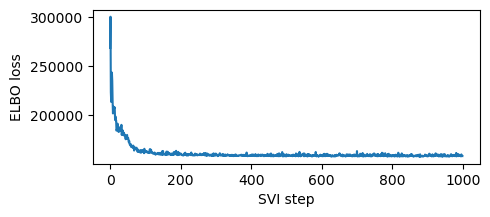

In [10]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

## Assessing inferred parameters

Below we show estimates of the inferred model parameters. To show this, here I am just taking a sample from the 
posterior fit (i.e. calling the guide with the optimized set of variational parameters). Surely this is not the optimal way to summarise the posterior fit. 

__However__, if I take multiple samples from the posterior and subseqently summarise the posterior samples (e.g. by median), due to label switching that occurs when sampling 
$\theta \sim Dir(\alpha)$, the posterior mode will be useless. 

__TODO__ 

1. Define a better way to summarize the posterior distribution from posterior samples. E.g. by fixing the label switching problem, post-hoc after sampling from the posterior (similar approach to mixture models).
2. Make posterior predictive checks.
3. Need to understand Pyro's `poutine`.


In [11]:
pyro.param("alpha_a_vi").detach() / pyro.param("alpha_b_vi").detach()

tensor([0.5096, 0.5964])

In [12]:
pyro.param("phi_vi").detach()

tensor([[3.2026e+00, 2.7838e-01, 7.0706e+00, 1.0654e+01, 1.0216e+01, 1.3465e+01,
         1.9335e+02, 1.7060e+03, 9.1660e-02, 1.2825e+02, 9.2663e-01, 2.6156e+02,
         1.7391e+02, 9.5221e-02, 3.6989e+00, 2.3300e+03, 1.0000e+02, 8.6585e+00,
         1.2250e+01, 9.0322e+00, 2.0868e+02, 6.6039e+01, 7.1771e+01, 1.7197e+02,
         1.9006e+02, 4.5013e+00, 1.9619e+02, 3.9294e+00, 6.7342e+01, 7.7056e+00,
         2.5129e+00, 4.7726e+02, 3.5234e-01, 3.3150e+00, 1.8756e+02, 1.5108e+00,
         5.2811e+02, 2.1730e+00, 6.8323e+01, 1.0917e+01, 3.6093e+02, 3.4210e+00,
         3.6740e+01, 1.4998e+01, 1.0206e+02, 6.3361e+01, 3.5807e+01],
        [2.0716e+02, 1.9627e+01, 1.4387e-01, 2.9839e+02, 2.0987e+02, 1.9291e-01,
         3.8042e+02, 4.2468e+01, 1.2037e+01, 4.5069e+02, 8.4231e+00, 2.2845e+01,
         3.9038e+02, 6.6638e+01, 8.7667e+00, 1.5114e+02, 2.8326e+00, 5.8743e+02,
         1.3984e+02, 2.5523e+00, 1.4495e+02, 2.6223e+01, 2.1703e+00, 5.2122e+02,
         1.9929e+01, 1.0750e+01, 6.4737

In [22]:
#for name, value in pyro.get_param_store().items():
#    print(name, pyro.param(name).data.cpu().numpy())

In [13]:
pyro.param("theta_vi").detach()[1:10, :]

tensor([[48.6184,  0.5110],
        [ 3.0659,  7.9648],
        [41.5203,  7.9801],
        [ 6.8803,  2.6842],
        [ 1.0471,  4.1949],
        [ 8.4504, 27.6266],
        [76.5707,  0.3292],
        [ 1.9048,  1.4440],
        [68.8418,  0.2321]])

In [14]:
# A single sample from the guide
post_sample = lda_guide(D = D, nTopics = nTopics, nRegions = nRegions)

In [15]:
obj_sim['theta_true'][1:10, ] # first 10 cells prob assignments to each topic

tensor([[3.7826e-02, 9.6217e-01],
        [6.6526e-01, 3.3474e-01],
        [2.8452e-01, 7.1548e-01],
        [2.5411e-01, 7.4589e-01],
        [6.7220e-01, 3.2780e-01],
        [7.3451e-01, 2.6549e-01],
        [2.0053e-04, 9.9980e-01],
        [4.0856e-01, 5.9144e-01],
        [3.5590e-03, 9.9644e-01]])

In [16]:
post_sample['theta'][1:10, :] # posterior theta

tensor([[0.9989, 0.0011],
        [0.6375, 0.3625],
        [0.9097, 0.0903],
        [0.8161, 0.1839],
        [0.3752, 0.6248],
        [0.1779, 0.8221],
        [0.9833, 0.0167],
        [0.9086, 0.0914],
        [0.9983, 0.0017]], grad_fn=<SliceBackward0>)

In [17]:
post_sample['phi'][:, 1:10].detach().numpy().transpose() # posterior phi

array([[3.5568009e-05, 2.5509396e-03],
       [1.3942810e-03, 1.2348128e-06],
       [1.0460377e-03, 3.6235780e-02],
       [8.9628127e-04, 2.0397356e-02],
       [1.3248972e-03, 1.3245256e-06],
       [2.8775601e-02, 4.1636534e-02],
       [2.1165957e-01, 5.6889239e-03],
       [1.8795549e-06, 1.1796952e-03],
       [1.6135693e-02, 4.9613699e-02]], dtype=float32)

In [18]:
d_str = []
for n in range(60):
    d_str.append('w{}'.format(n))
vocab = pd.DataFrame(columns=['id', 'index'])
vocab['id'] = d_str
vocab['index'] = vocab.index

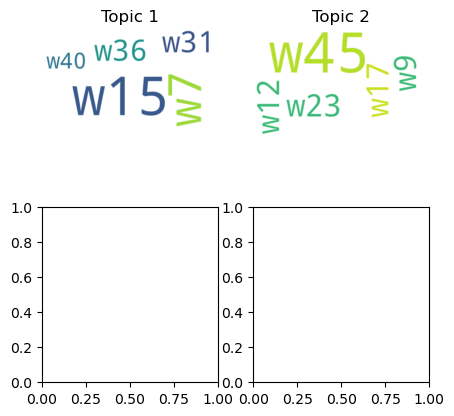

In [19]:
def plot_word_cloud(phi, vocab, max_ids, ax, title):
    """
    Word cloud visualisation helpful for interpreting topic-word distributions

    :param phi: Vector of word probabilities for specific topic
    :param vocab: Vocabulary array with columns ('id', 'index')
    :param max_ids: Maximum number of word ids to plot.
    :param ax: Axis object
    :param title: Plot title
    """
    sorted_, indices = torch.sort(phi, descending=True)
    df = pd.DataFrame(indices[:max_ids].numpy(), columns=['index'])
    words = pd.merge(df, vocab[['index', 'id']],
                     how='left', on='index')['id'].values.tolist()
    sizes = (sorted_[:100] * 10).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title(title)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    
phi = post_sample['phi']
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
for n in range(phi.shape[0]):
    i, j = divmod(n, 2)
    plot_word_cloud(scale_zero_one(phi[n]), vocab, 20, axs[i, j], 'Topic %d' % (n + 1))

plt.show()

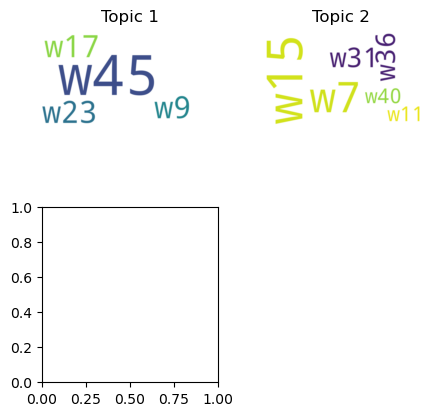

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
for n in range(obj_sim['phi_true'].shape[0]):
    i, j = divmod(n, 3)
    plot_word_cloud(scale_zero_one(obj_sim['phi_true'][n]), vocab, 20, axs[i, j], 'Topic %d' % (n + 1))
axs[-1, -1].axis('off');

plt.show()